# MNIST



In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
!pip install Pillow==4.1.1
!pip install "fastai==0.7.0"
!pip install torchtext==0.2.3


In [0]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.io import *

In [0]:
path = 'data/mnist/'

Let's download, unzip, and format the data.

In [0]:
import os
os.makedirs(path, exist_ok=True)

In [0]:
URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

In [0]:
get_data(URL+FILENAME, path+FILENAME)
((x, y), (x_valid, y_valid), _) = load_mnist(path+FILENAME)

In [0]:
type(x), x.shape, type(y), y.shape

(numpy.ndarray, (50000, 784), numpy.ndarray, (50000,))

### Normalize

Many machine learning algorithms behave better when the data is *normalized*, that is when the mean is 0 and the standard deviation is 1. We will subtract off the mean and standard deviation from our training set in order to normalize the data:

scaling is by the pixels

In [0]:
mean = x.mean()
std = x.std()

x=(x-mean)/std
mean, std, x.mean(), x.std()

(0.13044983, 0.3072898, -3.1638146e-07, 0.99999934)

Note that for consistency (with the parameters we learn when training), we subtract the mean and standard deviation of our training set from our validation set. 

In [0]:
'''
We are normalizing based on training set mean and std dev
as we are needed both set of numbers to be in same scale 
diff val and train set means diff scale of same numbers in 
diff dataset hence different final values


'''

x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(-0.005850922, 0.99243325)

### Look at the data

In any sort of data science work, it's important to look at your data, to make sure you understand the format, how it's stored, what type of values it holds, etc. To make it easier to work with, let's reshape it into 2d images from the flattened 1d format.

#### Helper methods

In [0]:
def show(img, title=None):
    plt.imshow(img, cmap="gray")
    if title is not None: plt.title(title)

In [0]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap='gray')

#### Plots 

In [0]:
x_valid.shape # the images are in shape of 1d tensor there are 10k images

(10000, 784)

In [0]:
'''
numpy reshapes 1d tensor to 2d and can take input of only 1 dimension as
it only needs n-1 dimensions out of n. last can be figured out. 

-1 means how large or small can it go to fit. it's actual value is 10k


(-1,28,28)
All neural networks, the first axis is a row, image, a sentence, 
example, then we reshape the last two axis

'''

x_imgs = np.reshape(x_valid, (-1,28,28)); x_imgs.shape

(10000, 28, 28)

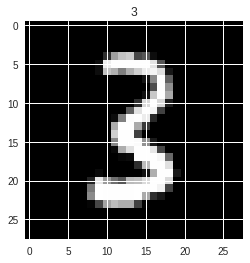

In [0]:
show(x_imgs[0], y_valid[0])

In [0]:
y_valid.shape #rank 1 tensor

(10000,)

It's the digit 3!  And that's stored in the y value:

In [0]:
y_valid[0]

3

We can look at part of an image:

In [0]:
x_imgs[0,10:15,10:15] # slicing 1st axis with 0  converting 3d matrix to 2d matrix

array([[-0.42452, -0.42452, -0.42452, -0.42452,  0.17294],
       [-0.42452, -0.42452, -0.42452,  0.78312,  2.43567],
       [-0.42452, -0.27197,  1.20261,  2.77889,  2.80432],
       [-0.42452,  1.76194,  2.80432,  2.80432,  1.73651],
       [-0.42452,  2.20685,  2.80432,  2.80432,  0.40176]], dtype=float32)

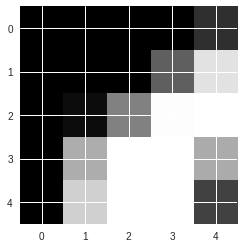

In [0]:
show(x_imgs[0,10:15,10:15])

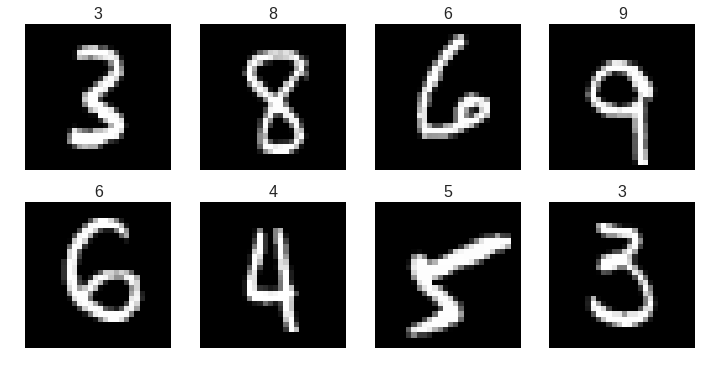

In [0]:
plots(x_imgs[:8], titles=y_valid[:8])

## Neural Networks

We will take a deep look *logistic regression* and how we can program it ourselves. We are going to treat it as a specific example of a shallow neural net.

**What is a neural network?**

A *neural network* is an *infinitely flexible function*, consisting of *layers*.  A *layer* is a linear function such as matrix multiplication followed by a non-linear function (the *activation*).

One of the tricky parts of neural networks is just keeping track of all the vocabulary! 

### Functions, parameters, and training

A **function** takes inputs and returns outputs. For instance, $f(x) = 3x + 5$ is an example of a function.  If we input $2$, the output is $3\times 2 + 5 = 11$, or if we input $-1$, the output is $3\times -1 + 5 = 2$

Functions have **parameters**. The above function $f$ is $ax + b$, with parameters a and b set to $a=3$ and $b=5$.

Machine learning is often about learning the best values for those parameters.  For instance, suppose we have the data points on the chart below.  What values should we choose for $a$ and $b$?

<img src="https://github.com/fastai/fastai/blob/master/courses/ml1/images/sgd2.gif?raw=1" alt="" style="width: 70%"/>

In the above gif from fast.ai's deep learning course, [intro to SGD notebook](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/sgd-intro.ipynb)), an algorithm called stochastic gradient descent is being used to learn the best parameters to fit the line to the data (note: in the gif, the algorithm is stopping before the absolute best parameters are found).  This process is called **training** or **fitting**.

Most datasets will not be well-represented by a line.  We could use a more complicated function, such as $g(x) = ax^2 + bx + c + \sin d$.  Now we have 4 parameters to learn: $a$, $b$, $c$, and $d$.  This function is more flexible than $f(x) = ax + b$ and will be able to accurately model more datasets.

Neural networks take this to an extreme, and are infinitely flexible.  They often have thousands, or even hundreds of thousands of parameters.  However the core idea is the same as above.  The neural network is a function, and we will learn the best parameters for modeling our data.

we are gonna use neural network to fit the line as it is inf flexible fxn

### PyTorch


The fastai deep learning library uses [PyTorch](http://pytorch.org/), a Python framework for dynamic neural networks with GPU acceleration, which was released by Facebook's AI team.

PyTorch has two overlapping, yet distinct, purposes.  As described in the [PyTorch documentation](http://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html):

<img src="https://github.com/fastai/fastai/blob/master/courses/ml1/images/what_is_pytorch.png?raw=1" alt="pytorch" style="width: 80%"/>

The neural network functionality of PyTorch is built on top of the Numpy-like functionality for fast matrix computations on a GPU. Although the neural network purpose receives way more attention, both are very useful.  We'll implement a neural net from scratch today using PyTorch.

**Further learning**: If you are curious to learn what *dynamic* neural networks are, you may want to watch [this talk](https://www.youtube.com/watch?v=Z15cBAuY7Sc) by Soumith Chintala, Facebook AI researcher and core PyTorch contributor.

If you want to learn more PyTorch, you can try this [introductory tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) or this [tutorial to learn by examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

## Neural Net for Logistic Regression in PyTorch

In [0]:
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *

import torch.nn as nn

We will begin with the highest level abstraction: using a neural net defined by PyTorch's Sequential class.  

In [0]:
# creating a neural nw in pytorch
# seq = you give layer names which needed to be included

net = nn.Sequential(
    nn.Linear(28*28, 10),  # y= ax+b matrix product output of size 100
    
    nn.LogSoftmax() # need non linearity after linear layer
).cuda()

# loss fxn is used to define inf gain the score of how good we are

# ouput will be the number of classes taken to classify 10 0 to 9 
# 0 is cat and 6 is dog etc


'''
this will build simple logistic regression

'''

'\nthis will build simple logistic regression\n\n'

In [0]:
'''
use this or above but this is better

this one adds another hidden layer

'''
net = nn.Sequential(
    nn.Linear(28*28, 100),  # y= ax+b matrix product output of size 100
    nn.ReLU(),
    nn.Linear(100,10),
    nn.LogSoftmax() # need non linearity after linear layer
).cuda()


Each input is a vector of size `28*28` pixels and our output is of size `10` (since there are 10 digits: 0, 1, ..., 9). 

We use the output of the final layer to generate our predictions.  Often for classification problems (like MNIST digit classification), the final layer has the same number of outputs as there are classes.  In that case, this is 10: one for each digit from 0 to 9.  These can be converted to comparative probabilities.  For instance, it may be determined that a particular hand-written image is 80% likely to be a 4, 18% likely to be a 9, and 2% likely to be a 3.

In [0]:
'''
path =  temp locn to save values
x,y :: training data

It takes mini batch and makes them variable

'''
md = ImageClassifierData.from_arrays(path, (x,y), (x_valid, y_valid))

In [0]:
loss=nn.NLLLoss()  # negative log likelihood loss or cross entropy
metrics=[accuracy]
# opt=optim.SGD(net.parameters(), 1e-1, momentum=0.9)
opt=optim.SGD(net.parameters(), 1e-1, momentum=0.9, weight_decay=1e-3)

# Nll or cross entropy is of 2 types binary and categorical we using 
# binary which is for only 2 items.


### Loss functions and metrics

In machine learning the **loss** function or cost function is representing the price paid for inaccuracy of predictions.

The loss associated with one example in binary classification is given by:
`-(y * log(p) + (1-y) * log (1-p))`
where `y` is the true label of `x` and `p` is the probability predicted by our model that the label is 1.

In [0]:
'''
acts 1 = cat 0 = dog 
and predictions 90 cat 10 dog 20 cat 80 dog
1st and 2nd predic will op same values as it is 
log of pred and log 

y can be only 0 or 1 so can use if statement
as the mult is by 0


'''

def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))
  
  

In [0]:
'''
in case of determining how far a prediction is from actual i.e. 
we predicting cat dog and plane how far is cat prediction from 
reality: plane. 

we use one hot encoding  category    cat dog plane  probability      calc binary entropy 
                            plane    0    0   1    (of being a plane)      value

categorical entropy = sum(binary entropies of all numbers/ categories 0 to 9)
i.e 10 predictions



'''



acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

0.164252033486018

Note that in our toy example above our accuracy is 100% and our loss is 0.16. Compare that to a loss of 0.03 that we are getting while predicting cats and dogs. Exercise: play with `preds` to get a lower loss for this example. 

**Example:** Here is an example on how to compute the loss for one example of binary classification problem. Suppose for an image x with label 1 and your model gives it a prediction of 0.9. For this case the loss should be small because our model is predicting a label $1$ with high probability.

`loss = -log(0.9) = 0.10`

Now suppose x has label 0 but our model is predicting 0.9. In this case our loss is should be much larger.

`loss = -log(1-0.9) = 2.30`

- Exercise: look at the other cases and convince yourself that this make sense.
- Exercise: how would you rewrite `binary_loss` using `if` instead of `*` and `+`?

Why not just maximize accuracy? The binary classification loss is an easier function to optimize.

For multi-class classification, we use *negative log liklihood* (also known as *categorical cross entropy*) which is exactly the same thing, but summed up over all classes.

### Fitting the model

*Fitting* is the process by which the neural net learns the best parameters for the dataset.

In [0]:
fit(net, md, n_epochs=5, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy   
    0      1.252922   1.614048   0.8372    
    1      1.28945    1.212888   0.8566    
    2      1.185147   0.990395   0.8848    
    3      1.184262   1.079819   0.8759    
    4      1.388976   1.237042   0.8642    



[array([1.23704]), 0.8642]

In [0]:
set_lrs(opt, 1e-2)

In [0]:
fit(net, md, n_epochs=3, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy   
    0      0.487398   0.466385   0.9214    
    1      0.344212   0.361717   0.9234    
    2      0.305332   0.328788   0.9241    



[array([0.32879]), 0.9241]

In [0]:
fit(net, md, n_epochs=5, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy   
    0      0.328449   0.30939    0.9221    
    1      0.318823   0.292995   0.9224    
    2      0.283714   0.296238   0.9212    
    3      0.293835   0.298435   0.9183    
    4      0.306891   0.292576   0.9174    



[array([0.29258]), 0.9174]

In [0]:
set_lrs(opt, 1e-2)

In [0]:
fit(net, md, n_epochs=3, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy   
    0      0.278651   0.290759   0.9176    
    1      0.276023   0.280852   0.9228    
    2      0.263586   0.274007   0.9247    



[array([0.27401]), 0.9247]

In [0]:
t = [o.numel() for o in net.parameters()]
t, sum(t)

([7840, 10], 7850)

GPUs are great at handling lots of data at once (otherwise don't get performance benefit).  We break the data up into **batches**, and that specifies how many samples from our dataset we want to send to the GPU at a time.  The fastai library defaults to a batch size of 64.  On each iteration of the training loop, the error on 1 batch of data will be calculated, and the optimizer will update the parameters based on that.

An **epoch** is completed once each data sample has been used once in the training loop.

Now that we have the parameters for our model, we can make predictions on our validation set.

In [0]:
preds = predict(net, md.val_dl)

In [0]:
preds.shape

(10000, 10)

**Question**: Why does our output have length 10 (for each image)?

10k images for validation 
we make 10 predictions per image

In [0]:
preds.argmax(axis=1)[:5]  # tke arr of preds find highest val index
# grab first 5 in col and print max index

array([3, 8, 6, 9, 6])

In [0]:
preds = preds.argmax(1)

Let's check how accurate this approach is on our validation set. You may want to compare this against other implementations of logistic regression, such as the one in sklearn. In our testing, this simple pytorch version is faster and more accurate for this problem!

In [0]:
np.mean(preds == y_valid)

0.9247

Let's see how some of our predictions look!

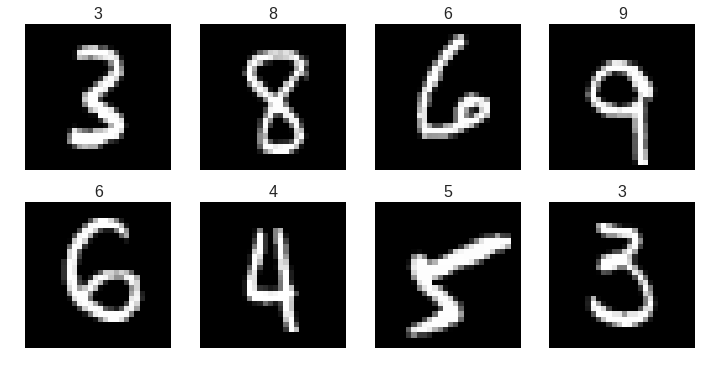

In [0]:
plots(x_imgs[:8], titles=preds[:8])

## Defining Logistic Regression Ourselves

Above, we used pytorch's `nn.Linear` to create a linear layer.  This is defined by a matrix multiplication and then an addition (these are also called `affine transformations`).  Let's try defining this ourselves.

Just as Numpy has `np.matmul` for matrix multiplication (in Python 3, this is equivalent to the `@` operator), PyTorch has `torch.matmul`.  

Our PyTorch class needs two things: constructor (says what the parameters are) and a forward method (how to calculate a prediction using those parameters)  The method `forward` describes how the neural net converts inputs to outputs.

In PyTorch, the optimizer knows to try to optimize any attribute of type **Parameter**.

In [0]:
'''
torch.randn builds number with random dist
in dl if we increase no. of layers weight matrix is of appropriate size
so it does not cause any prob in future when there is change in input
mean of input to matrix does not change so we divide by dims[0]

it will basically generate numbers with mean =0 std dev = 1

'''

def get_weights(*dims): return nn.Parameter(torch.randn(dims)/dims[0])
# param tells which things to update when it does stoc grad desc

def softmax(x): return torch.exp(x)/(torch.exp(x).sum(dim=1)[:,None])


'''
creating a pytorch module


bias as in y = mx+ b(bias)
different for every pt

'''


# superclass nn.Module is inherited by logreg 
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()  # construct superclass first
        self.l1_w = get_weights(28*28, 10)  # Layer 1 weights
        self.l1_b = get_weights(10)         # Layer 1 bias

# afte multiplication we are getting a 28row X 28 colm matrix and we 
# need to flatten it out
# 
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # reshape/flatten the matrix to vector
        x = (x @ self.l1_w) + self.l1_b  # Linear Layer
        x = torch.log(softmax(x)) # Non-linear (LogSoftmax) Layer [takes e^ of 
                                  #  o/p of linear layer
        return x

We create our neural net and the optimizer.  (We will use the same loss and metrics from above).

In [0]:
net2 = LogReg().cuda()
opt=optim.Adam(net2.parameters())

In [0]:
fit(net2, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy   
    0      0.324897   0.281418   0.9206    



[array([0.28142]), 0.9206]

In [0]:
# md.trn_dl is data loader training data loader and turn it into iterator
# so we can grab one at a time
dl = iter(md.trn_dl)

In [0]:
# grab one more thing from generator
xmb,ymb = next(dl)

#returns tensor of size 64 784  mini batch size of 64

In [0]:
'''
var x mini batch
pytorch will automatically differentiate the tensors but to do
that you need to keep record of all changes and chain multiply 
them so use Variable : same as tensor but keeps track of changes
less strain

'''
vxmb = Variable(xmb.cuda())
vxmb

Variable containing:
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
          ...             ⋱             ...          
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
-0.4245 -0.4245 -0.4245  ...  -0.4245 -0.4245 -0.4245
[torch.cuda.FloatTensor of size 64x784 (GPU 0)]

In [0]:
preds = net2(vxmb).exp(); preds[:3]

Variable containing:

Columns 0 to 5 
 1.7534e-04  3.4398e-08  2.4604e-04  1.8413e-05  9.7433e-01  9.0401e-05
 1.1642e-05  4.7637e-07  1.7783e-03  2.7140e-04  3.2470e-03  7.4107e-04
 9.9872e-01  1.8375e-12  3.0201e-05  2.1513e-04  5.1182e-11  7.0344e-04

Columns 6 to 9 
 1.0183e-03  3.5089e-05  6.9588e-04  2.3391e-02
 5.3063e-02  1.0884e-06  9.4018e-01  7.0657e-04
 3.1102e-09  2.1748e-08  3.3508e-04  6.0495e-09
[torch.cuda.FloatTensor of size 3x10 (GPU 0)]

In [0]:
# pytorch does not take argmax have max max(1) returns values and 
# their index so we are just taking indices down using max(1)[1]

preds = preds.data.max(1)[1]; preds

Let's look at our predictions on the first eight images:

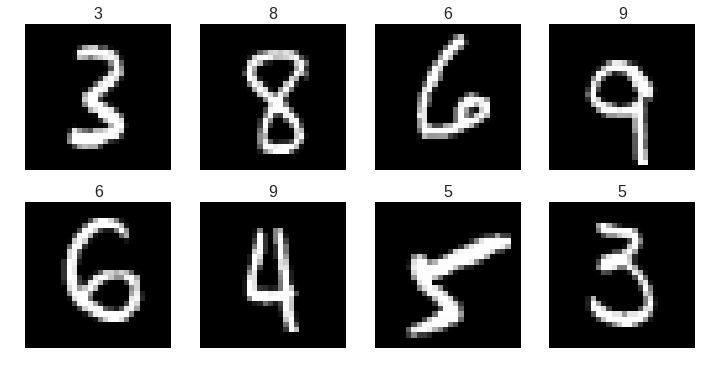

In [0]:
preds = predict(net2, md.val_dl).argmax(1)
plots(x_imgs[:8], titles=preds[:8])

In [0]:
 np.mean(preds == y_valid)

0.9206

## Aside about Broadcasting and Matrix Multiplication

Now let's dig in to what we were doing with `torch.matmul`: matrix multiplication.  First, let's start with a simpler building block: **broadcasting**.

### Element-wise operations 

Broadcasting and element-wise operations are supported in the same way by both numpy and pytorch.

Operators (+,-,\*,/,>,<,==) are usually element-wise.

Examples of element-wise operations:

In [0]:
a = np.array([10, 6, -4])
b = np.array([2, 8, 7])
a,b

In [0]:
a + b

In [0]:
(a < b).mean()

### Broadcasting

#### Broadcasting with a scalar

In [0]:
m = np.array([[1, 2, 3], [4,5,6], [7,8,9]]); m

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [0]:
2*m # it is multiplication of a scalar which pretends to be a
    # var of higher dimensionality 

#### Broadcasting a vector to a matrix

We can also broadcast a vector to a matrix:

In [0]:
c = np.array([10,20,30]); c

array([10, 20, 30])

In [0]:
m + c

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

In [0]:
# to get new columns instead of rows[like above]
 # make it a col matrix using column_stack(c) 

array([[10, 20, 30]])

Although numpy does this automatically, you can also use the `broadcast_to` method:

In [0]:
c.shape

(3,)

In [0]:
np.broadcast_to(c[:,None], m.shape)

array([[10, 10, 10],
       [20, 20, 20],
       [30, 30, 30]])

In [0]:
np.broadcast_to(np.expand_dims(c,0), (3,3))

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

In [0]:
c.shape

(3,)

In [0]:
np.expand_dims(c,0).shape

(1, 3)

The numpy `expand_dims` method lets us convert the 1-dimensional array `c` into a 2-dimensional array (although one of those dimensions has value 1).

In [0]:
np.expand_dims(c,0).shape

(1, 3)

In [0]:
m + np.expand_dims(c,0)

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

In [0]:
np.expand_dims(c,1)

array([[10],
       [20],
       [30]])

In [0]:
c[:, None].shape

(3, 1)

In [0]:
m + np.expand_dims(c,1)

array([[11, 12, 13],
       [24, 25, 26],
       [37, 38, 39]])

In [0]:
np.broadcast_to(np.expand_dims(c,1), (3,3))

array([[10, 10, 10],
       [20, 20, 20],
       [30, 30, 30]])

#### Broadcasting Rules

In [0]:
c[None]

In [0]:
c[:,None]

In [0]:
c[None] > c[:,None]

In [0]:
xg,yg = np.ogrid[0:5, 0:5]; xg,yg

In [0]:
xg+yg

When operating on two arrays, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when

- they are equal, or
- one of them is 1

Arrays do not need to have the same number of dimensions. For example, if you have a `256*256*3` array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3

The [numpy documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) includes several examples of what dimensions can and can not be broadcast together.

### Matrix Multiplication

We are going to use broadcasting to define matrix multiplication.

In [0]:
m, c

In [0]:
m @ c  # np.matmul(m, c)

We get the same answer using `torch.matmul`:

In [0]:
T(m) @ T(c)

The following is **NOT** matrix multiplication.  What is it?

In [0]:
m,c

In [0]:
m * c

In [0]:
(m * c).sum(axis=1)

In [0]:
c

In [0]:
np.broadcast_to(c, (3,3))

From a machine learning perspective, matrix multiplication is a way of creating features by saying how much we want to weight each input column.  **Different features are different weighted averages of the input columns**. 

The website [matrixmultiplication.xyz](http://matrixmultiplication.xyz/) provides a nice visualization of matrix multiplcation

In [0]:
n = np.array([[10,40],[20,0],[30,-5]]); n

In [0]:
m

In [0]:
m @ n

In [0]:
(m * n[:,0]).sum(axis=1)

In [0]:
(m * n[:,1]).sum(axis=1)

## Writing Our Own Training Loop

As a reminder, this is what we did above to write our own logistic regression class (as a pytorch neural net):

In [0]:
# Our code from above
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10)  # Layer 1 weights
        self.l1_b = get_weights(10)         # Layer 1 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = x @ self.l1_w + self.l1_b 
        return torch.log(softmax(x))

net2 = LogReg().cuda()
opt=optim.Adam(net2.parameters())

fit(net2, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics)

Above, we are using the fastai method `fit` to train our model.  Now we will try writing the training loop ourselves.

**Review question:** What does it mean to train a model?

We will use the LogReg class we created, as well as the same loss function, learning rate, and optimizer as before:

In [0]:
net2 = LogReg().cuda()
loss=nn.NLLLoss()
learning_rate = 1e-3
optimizer=optim.Adam(net2.parameters(), lr=learning_rate)

md is the ImageClassifierData object we created above.  We want an iterable version of our training data (**question**: what does it mean for something to be iterable?):

In [0]:
dl = iter(md.trn_dl) # Data loader

First, we will do a **forward pass**, which means computing the predicted y by passing x to the model.

In [0]:
xt, yt = next(dl)
y_pred = net2(Variable(xt).cuda())

We can check the loss:

In [0]:
l = loss(y_pred, Variable(yt).cuda())
print(l)

We may also be interested in the accuracy.  We don't expect our first predictions to be very good, because the weights of our network were initialized to random values.  Our goal is to see the loss decrease (and the accuracy increase) as we train the network:

In [0]:
np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))

Now we will use the optimizer to calculate which direction to step in.  That is, how should we update our weights to try to decrease the loss?

Pytorch has an automatic differentiation package ([autograd](http://pytorch.org/docs/master/autograd.html)) that takes derivatives for us, so we don't have to calculate the derivative ourselves!  We just call `.backward()` on our loss to calculate the direction of steepest descent (the direction to lower the loss the most).

In [0]:
# Before the backward pass, use the optimizer object to zero all of the
# gradients for the variables it will update (which are the learnable weights
# of the model)
optimizer.zero_grad()

# Backward pass: compute gradient of the loss with respect to model parameters
l.backward()

# Calling the step function on an Optimizer makes an update to its parameters
optimizer.step()

Now, let's make another set of predictions and check if our loss is lower:

In [0]:
xt, yt = next(dl)
y_pred = net2(Variable(xt).cuda())

In [0]:
l = loss(y_pred, Variable(yt).cuda())
print(l)

Note that we are using **stochastic** gradient descent, so the loss is not guaranteed to be strictly better each time.  The stochasticity comes from the fact that we are using **mini-batches**; we are just using 64 images to calculate our prediction and update the weights, not the whole dataset.

In [0]:
np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))

If we run several iterations in a loop, we should see the loss decrease and the accuracy increase with time.

In [0]:
for t in range(100):
    xt, yt = next(dl)
    y_pred = net2(Variable(xt).cuda())
    l = loss(y_pred, Variable(yt).cuda())
    
    if t % 10 == 0:
        accuracy = np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))
        print("loss: ", l.data[0], "\t accuracy: ", accuracy)

    optimizer.zero_grad()
    l.backward()
    optimizer.step()

### Put it all together in a training loop

In [0]:
def score(x, y):
    y_pred = to_np(net2(V(x)))
    return np.sum(y_pred.argmax(axis=1) == to_np(y))/len(y_pred) 
  
  # return statement is generator and 

In [0]:
'''
variable can track all the steps to get computed 
autograd in pytorch and variable class search



'''


net2 = LogReg().cuda()
loss=nn.NLLLoss()
learning_rate = 1e-2
optimizer=optim.SGD(net2.parameters(), lr=learning_rate)

for epoch in range(1):  # go through 1 epoch
    losses=[]
    dl = iter(md.trn_dl) # convert training loader to iterator
    for t in range(len(dl)):
        # Forward pass: compute predicted y and loss by passing x to the model.
        xt, yt = next(dl)
        y_pred = net2(V(xt)) # converting into variable V()
        l = loss(y_pred, V(yt))
        losses.append(l)

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable weights of the model)
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        l.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
    
    val_dl = iter(md.val_dl)
    val_scores = [score(*next(val_dl)) for i in range(len(val_dl))]
    print(np.mean(val_scores))

## Stochastic Gradient Descent

Nearly all of deep learning is powered by one very important algorithm: **stochastic gradient descent (SGD)**. SGD can be seeing as an approximation of **gradient descent (GD)**. In GD you have to run through all the samples in your training set to do a single itaration. In SGD you use only a subset of training samples to do the update for a parameter in a particular iteration. The subset used in each iteration is called a batch or minibatch.

Now, instead of using the optimizer, we will do the optimization ourselves!

In [0]:
net2 = LogReg().cuda()
loss_fn=nn.NLLLoss()
lr = 1e-2
w,b = net2.l1_w,net2.l1_b

for epoch in range(1):
    losses=[]
    dl = iter(md.trn_dl)
    for t in range(len(dl)):
        xt, yt = next(dl)
        y_pred = net2(V(xt))
        l = loss(y_pred, Variable(yt).cuda())
        losses.append(loss)

        # Backward pass: compute gradient of the loss with respect to model parameters
        l.backward()
        w.data -= w.grad.data * lr
        b.data -= b.grad.data * lr
        
        w.grad.data.zero_()
        b.grad.data.zero_()   

    val_dl = iter(md.val_dl)
    val_scores = [score(*next(val_dl)) for i in range(len(val_dl))]
    print(np.mean(val_scores))